In [2]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext
import math
from functools import lru_cache

## Задача 1

In [3]:
###############################################################################
#  1) Вспомогательные функции для разностных квадратур                        #
###############################################################################
getcontext().prec = 100  # повышенная точность для Decimal

@lru_cache(None)
def factorial_dec(n: int) -> Decimal:
    if n < 0:
        raise ValueError("Negative factorial not defined")
    if n == 0 or n == 1:
        return Decimal(1)
    return Decimal(n) * factorial_dec(n - 1)

@lru_cache(None)
def comb_dec(n: int, k: int) -> Decimal:
    if k < 0 or k > n:
        return Decimal(0)
    return factorial_dec(n) / (factorial_dec(k) * factorial_dec(n - k))

@lru_cache(None)
def D(n: int, j: int) -> Decimal:
    """
    Вычисляет D_n^(j) по заданной рекуррентной формуле (см. теорию).
    """
    if j == 0:
        return Decimal(1)
    # "прогреваем" кэш:
    _ = D(n, j-1)
    return _compute_all_D_up_to(n, j)[j]

@lru_cache(None)
def _compute_all_D_up_to(n: int, J: int):
    results = [Decimal(0)]*(J+1)
    results[0] = Decimal(1)
    for j in range(J):
        s = Decimal(0)
        for k in range(n + 2*j + 1):
            for l in range(j+1):
                val = (
                    Decimal((-1)**k)
                    * results[l]
                    * comb_dec(n+2*l, k - (j - l))
                    * Decimal((n + 2*j - 2*k)**(n + 2*j + 2))
                    / (Decimal(2)**(n + 2*j + 2) * factorial_dec(n + 2*j + 2))
                )
                s += val
        # Финальная формула берёт только s, без + results[j].
        results[j+1] = s
    return results

@lru_cache(None)
def A(k: int, n: int, m: int) -> Decimal:
    """
    A_{k,n}^m = sum_{l=0}^m [ (-1)^(k-m) * D_n^(l) * C_{n+2l}^{k - m + l} ].
    """
    s = Decimal(0)
    sign = Decimal((-1)**(k - m))
    for l in range(m+1):
        s += (
            sign
            * D(n, l)
            * comb_dec(n+2*l, k - m + l)
        )
    return s

@lru_cache(None)
def W_km(k: int, m: int):
    s = Decimal(0)
    for n_ in range(m+1):
        a_val = A(k, 2*n_, m - n_)
        denom = (Decimal(2)**(2*n_) * factorial_dec(2*n_+1))
        s += a_val / denom
    return s

@lru_cache(None)
def W_list(m: int):
    """
    Коэффициенты W_k^m (k=0..2m) в Decimal.

      W_k^m = sum_{n=0}^m [ A_{k,2n}^{m-n} / (2^(2n)*(2n+1)!) ].
    """
    result = []
    for k in range(2*m + 1):
        result.append(W_km(k, m))
    return result


@lru_cache(None)
def I_ml(m: int, l:int):
    s = Decimal(0)
    for k in range(l+1):
        s += W_km(2**m - k, m)
    return s

def build_function_values_diff_scheme(f, a: float, b: float, J: int, m: int):
    """
    Центральная сетка: x_j = a + (j+0.5)*h, j=-m..(J-1+m).
    Возвращает (y_values, h, calls).
    """
    h = (b - a)/J
    values = []
    for j_real in range(-m, (J - 1) + m + 1):
        x_val = a + (j_real + 0.5)*h
        values.append(f(x_val))
    calls = len(values)
    return values, h, calls

def integrate_by_diff_scheme(f, a: float, b: float, J: int, m: int):
    """
    Разностная (дифференсная) квадратура порядка 2m:
      ∫[a..b] f(x) dx ≈ h Σ_j Σ_k [ W_{m-k} * f( x_{j+k} ) ].
    Возвращает (approx, calls).
    """
    y_values, h, calls = build_function_values_diff_scheme(f, a, b, J, m)
    W_dec = W_list(m)
    W = [float(wd) for wd in W_dec]
    
    offset = m
    total_sum = 0.0
    for j in range(J):
        loc_sum = 0.0
        for k in range(-m, m+1):
            idx = (j + k) + offset
            loc_sum += W[m - k] * y_values[idx]
        total_sum += loc_sum
    return (h * total_sum, calls)

###############################################################################
#                             3) Основная часть                                #
###############################################################################

def main():
    # ------------------------------------------------------
    # Пример 1: f1(x)= sin(3x)/(1 + x^2) на [0,1].
    # Нет простого закрытого выражения; оставляем без аналитической формулы.
    # ------------------------------------------------------
    def f1(x: float) -> float:
        return math.sin(x/2)/(math.exp(x) - 1)

    exact_val_1 = 1.01304

    a1, b1 = -1.0, 1.0
    print("\n=========== Задание 1 ===========")
    print("Интеграл: I1 = ∫[-1..1] sin(x/2)/(e^x - 1) dx")
    print("Значение по wofram =  1.01304\n")

    for m in [4, 5, 6, 7]:
        print(f"--- m={m} ---")
        for J in [2, 4, 8, 16]:
            diff_approx, diff_calls = integrate_by_diff_scheme(f1, a1, b1, J, m)
            diff_err = abs(diff_approx - exact_val_1)

            print(f" J={J}, calls={diff_calls:2d} | "
                  f"DiffScheme={diff_approx:.8f}, err={diff_err:.2e} | ")
        print()



In [4]:
main()


=========== Задание 1 ===========
Интеграл: I1 = ∫[-1..1] sin(x/2)/(e^x - 1) dx
Значение по wofram =  1.01304

--- m=4 ---
 J=2, calls=10 | DiffScheme=1.01303816, err=1.84e-06 | 
 J=4, calls=12 | DiffScheme=1.01303923, err=7.65e-07 | 
 J=8, calls=16 | DiffScheme=1.01303924, err=7.64e-07 | 
 J=16, calls=24 | DiffScheme=1.01303924, err=7.64e-07 | 

--- m=5 ---
 J=2, calls=12 | DiffScheme=1.01303887, err=1.13e-06 | 
 J=4, calls=14 | DiffScheme=1.01303924, err=7.64e-07 | 
 J=8, calls=18 | DiffScheme=1.01303924, err=7.64e-07 | 
 J=16, calls=26 | DiffScheme=1.01303924, err=7.64e-07 | 

--- m=6 ---
 J=2, calls=14 | DiffScheme=1.01303908, err=9.18e-07 | 
 J=4, calls=16 | DiffScheme=1.01303924, err=7.64e-07 | 
 J=8, calls=20 | DiffScheme=1.01303924, err=7.64e-07 | 
 J=16, calls=28 | DiffScheme=1.01303924, err=7.64e-07 | 

--- m=7 ---
 J=2, calls=16 | DiffScheme=1.01303916, err=8.40e-07 | 
 J=4, calls=18 | DiffScheme=1.01303924, err=7.64e-07 | 
 J=8, calls=22 | DiffScheme=1.01303924, err=7.64e-

In [35]:
getcontext().prec = 50 

def sum_of_big_series(a_j, j_m, m):
    integral = -Decimal((j_m - 1/2))*Decimal(np.log((j_m -1/2)/(j_m + 1/2)))
    sum1 = Decimal(0)
    sum2 = Decimal(0)
    for j in range(2, j_m-m+1):
        sum1+= Decimal(a_j(j))
    
    for j in range(j_m - m + 1, j_m + m + 1):
        sum2 += Decimal((1 - I_ml(m, j + m - j_m - 1))) * Decimal(a_j(j))
  
    return integral + sum1 + sum2


In [56]:
def a_n(n):
    return 1/(n+0.5) + np.log((n-1)/(n))

In [51]:
print(sum_of_big_series(a_n, 1_000_000, 10))

gamma_em = Decimal(0.57721566490153286060651209008240243104215933593992)

0.29684385932839278586532507340795677963640741836622


In [46]:
j_m = np.astype(np.linspace(10_000, 5_000_000, 50), int)

sum_value = []
i = 0
for j in j_m:
    sum_value.append(sum_of_big_series(a_n, j, 7))
    print(i)
    i += 1
sum_value = np.array(sum_value)

0
1
2
3
4
5


KeyboardInterrupt: 

In [57]:
print(sum_of_big_series(a_n, 300_000, 10))

0.29684502590975770030508066525502808286063327614190


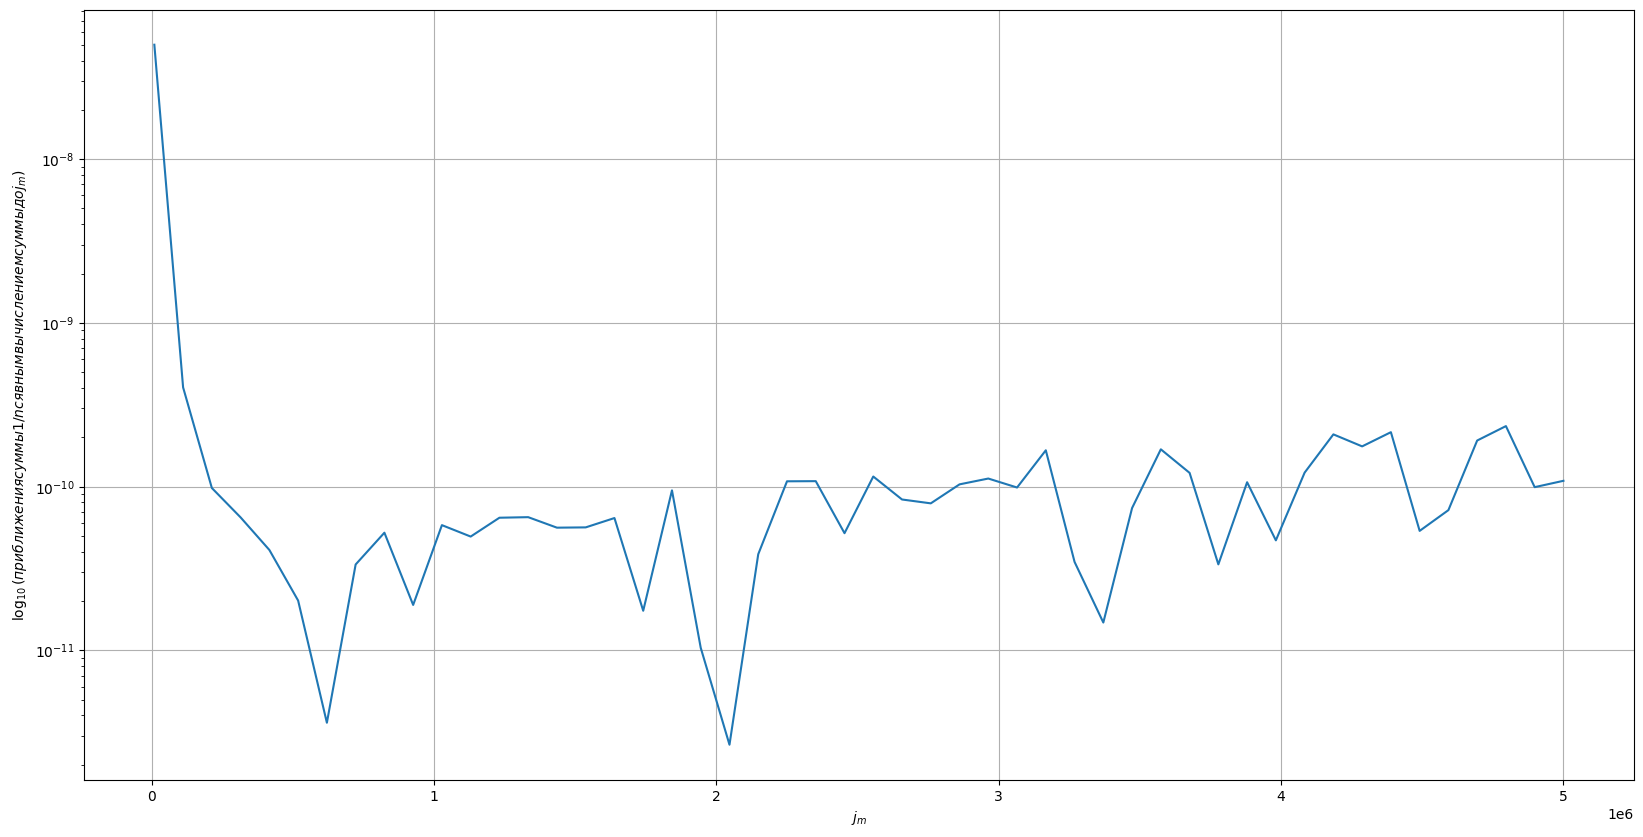

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(j_m, np.abs(sum_value - gamma_em))
plt.grid()
plt.yscale('log')
plt.ylabel('$\\log_{10} (приближения суммы 1/n с явным вычислением суммы до j_m)$')
plt.xlabel('$j_m$')
plt.show()

## Задача 3

In [10]:
def S_n(n):
    s = 0
    for j in range(1, n):
        s += np.cos(2 * j) / j**2 / (j**4 + j**2 +1)
    return s


print("S =", np.pi**2 / 6 - np.pi / 6 + 1 - S_n(10))

S = 2.2667285180426155


## Задача 4

In [11]:
def y(x_value):
    if x_value < 0:
        return np.cosh(np.sqrt(abs(x_value)))
    elif x_value > 0:
        return np.cos(np.sqrt(abs(x_value)))
    else:
        return 1

def limit(x_value, step):
    x_values = [x_value - step, x_value + step]
    y_values = [y(val) for val in x_values]
    numerator = y_values[0] - 1
    return numerator / (step)

real_value = 0.5

# Заданный предел
x_value = 0
steps = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14]  # различные значения шага
lims = []
# Вычисление предела для различных значений шага
for step in steps:
    lim = limit(x_value, step)
    lims.append(lim)
    print(f"Шаг = {step}, Предел = {lim}, Погрешность = {abs((lim - real_value))/real_value}")

Шаг = 0.1, Предел = 0.504180580384721, Погрешность = 0.008361160769442044
Шаг = 0.01, Предел = 0.5004168055803504, Погрешность = 0.0008336111607007979
Шаг = 0.001, Предел = 0.5000416680556174, Погрешность = 8.333611123489959e-05
Шаг = 0.0001, Предел = 0.5000041666813893, Погрешность = 8.333362778500941e-06
Шаг = 1e-05, Предел = 0.5000004166699767, Погрешность = 8.333399534876662e-07
Шаг = 1e-06, Предел = 0.5000000415922301, Погрешность = 8.318446020894044e-08
Шаг = 1e-07, Предел = 0.5000000036226027, Погрешность = 7.245205324579729e-09
Шаг = 1e-08, Предел = 0.4999999969612645, Погрешность = 6.07747097092215e-09
Шаг = 1e-09, Предел = 0.5000000413701855, Погрешность = 8.274037099909037e-08
Шаг = 1e-10, Предел = 0.5000000413701855, Погрешность = 8.274037099909037e-08
Шаг = 1e-11, Предел = 0.5000000413701855, Погрешность = 8.274037099909037e-08
Шаг = 1e-12, Предел = 0.5000444502911705, Погрешность = 8.890058234101161e-05
Шаг = 1e-13, Предел = 0.49960036108132044, Погрешность = 0.0007992778

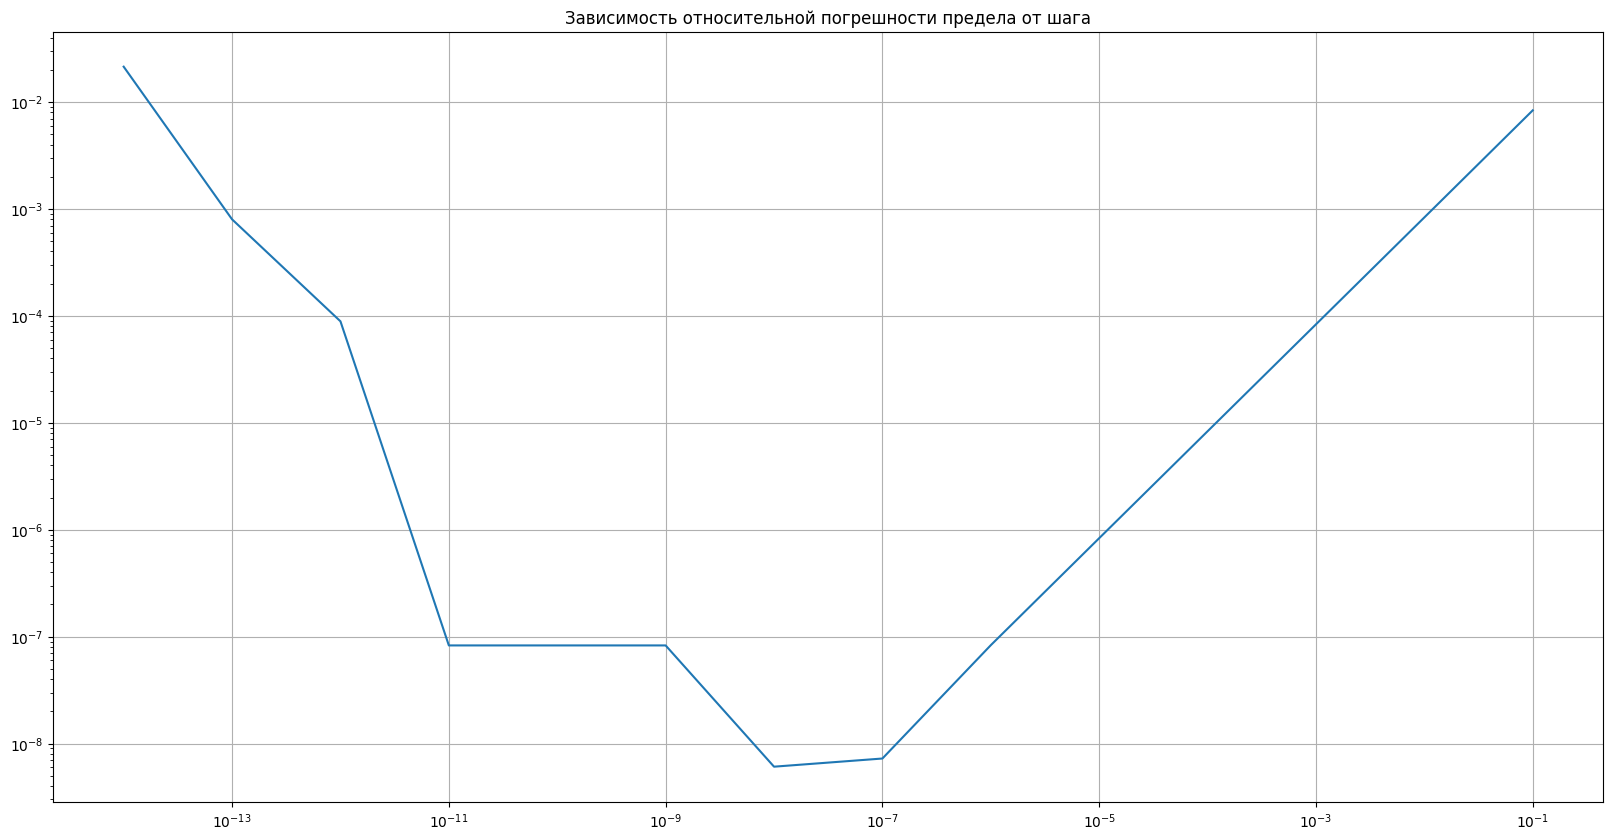

In [12]:
plt.figure(figsize = (20, 10))
plt.loglog(steps, abs((np.array(lims) - abs(real_value)))/real_value)
plt.grid()
plt.title('Зависимость относительной погрешности предела от шага')
plt.show()